In [7]:
import matplotlib.pyplot as plt
import numpy as np
import math

## capacitor differential equation

we're going to first test the capacitor differential equation and see its effect.

i picked up the code from https://www.billconnelly.net/?p=421. i'm gonna try and figure out what's going on here.

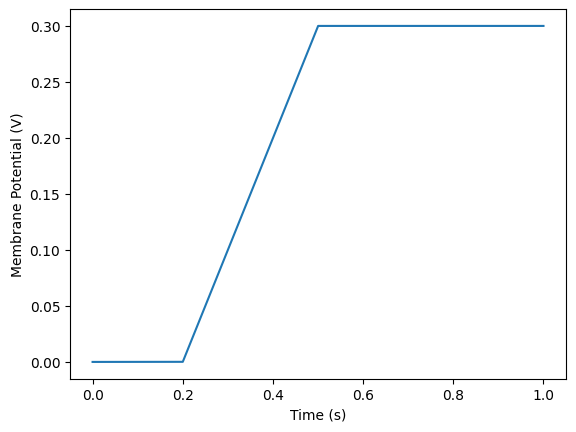

In [8]:
# Basic simulation Properties
dt = 10E-6; # 10 us timestep
 
# Basic Cell Properties
Cm = 100E-12; # Membrane Capacitance = 100 pF
v_init = -70E-3;# Initial membrane potential -70 mV
 
# Injected Current step
current_magnitude = 100E-12; # 100 pA
 
#Injected current, 0.2 seconds of 0 current, 0.3 seconds of some current,
#and 0.5 seconds of no current
i_inj = np.concatenate((
    np.zeros(round(0.2/dt)), 
    current_magnitude*np.ones(round(0.3/dt)), 
    np.zeros(round(0.5/dt))
))

#Preallocate the voltage output
v_out = np.zeros(np.size(i_inj))
 
#The real computational meat
for t in range(1, np.size(v_out)):
    if t == 0:
        v_out[t] = v_init; #At the first time step, set voltage to the initial condition
    else:
        i_cap = i_inj[t];   #Calculate what i is
        dv = i_cap/Cm * dt; #Calculate dv, using our favourite equation
        v_out[t] = v_out[t-1] + dv; #add dv on to our last known voltage
 
#Make the graph
t_vec = np.linspace(0, 1, np.size(v_out))
plt.plot(t_vec, v_out)
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential (V)')
plt.show()


so when a neuron gets excited, there's a temporary spike. in the above, we had a spike from 0.2 to 0.6 causing the potential to increase.

because of a lack of ion channels, the spike was permanent, and the change in membrane potential was fixed. why? 

theoretically, from a hodgekin-huxley circuit point of view, because the capacitor potential is increased with the incoming charge, and there's no subsequent discharge, leaving the potential at its fixed level.

practically, the incoming charges causes a permanent charge imbalance between the inside and outside of the membrane, causing a permanently changed potential.

now, we'll add an outgoing ion current through an ion channel.  

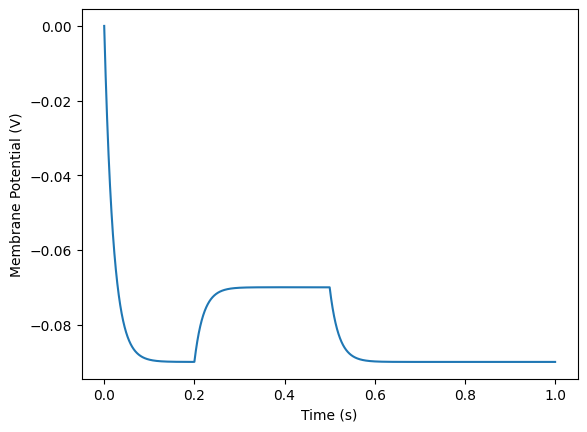

In [9]:
# Basic simulation Properties
dt = 10E-6; # 10 us timestep
 
# Basic Cell Properties
Cm = 100E-12; # Membrane Capacitance = 100 pF
v_init = -70E-3;# Initial membrane potential -70 mV

Gk = 5E-9 # 5 nS conductance
Ek = -90E-3 # Reversal potential of -90 mV

# Injected Current step
current_magnitude = 100E-12; # 100 pA
 
#Injected current, 0.2 seconds of 0 current, 0.3 seconds of some current,
#and 0.5 seconds of no current
i_inj = np.concatenate((
    np.zeros(round(0.2/dt)), 
    current_magnitude*np.ones(round(0.3/dt)), 
    np.zeros(round(0.5/dt))
))

#Preallocate the voltage output
v_out = np.zeros(np.size(i_inj))
 
#The real computational meat
for t in range(1, np.size(v_out)):
    if t == 0:
        v_out[t] = v_init; #At the first time step, set voltage to the initial condition
    else:
        i_ion = Gk * (v_out[t-1] - Ek)  #Calculate the current through ion channels
        i_cap = i_inj[t] - i_ion;   #Calculate what i is
        dv = i_cap/Cm * dt; #Calculate dv, using our favourite equation
        v_out[t] = v_out[t-1] + dv; #add dv on to our last known voltage
 
#Make the graph
t_vec = np.linspace(0, 1, np.size(v_out))
plt.plot(t_vec, v_out)
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential (V)')
plt.show()


why did the membrane potential become constant after the temporary spike?
    
before the input current started, the outgoing ion current was ongoing. this current was a positive ion (K+) going from inside to outside, leaving the potential to become increasingly negative. 

but, at a certain potential, after a sharp decline, the potential became fixed at a constant. here, the potential would've become equal to the Nernst value (-0.09V) i.e. the concentration of K+ became equal outside and inside the cell, and no further movement of ions happened. 

when the input current started, there was some movement of positive charges into the cell. from 0.2 to 0.6, this current motion netted to a certain value of membrane potential.

after the input current stopped, the outgoing current didn't stop, causing a sharp decrease, and then again tending to a constant value - again equal to Nernst value (-0.09V).

In [32]:
def alpha_n(v):
    v = v*1000
    return 0.01 * (-v-55)/( math.exp((-v-55)/10.0) -1) * 1000
 
def beta_n(v):
    v = v*1000
    return 0.125*math.exp((-v-65)/80.0) * 1000

In [59]:
# Basic simulation Properties
dt     = 10E-7;     # 10 us timestep
 
# Basic Cell Properties
Cm     = 100E-12;   # Membrane Capacitance = 100 pF
v_init = -70E-3;    # Initial membrane potential -70 mV

Gbar_k = 1E-6      # Maximum potassium conductance
Gleak  = 5E-9       # 5 nS conductance
 
Ek     = -80E-3     # Reversal for HH potassium current
Eleak  = -70E-3     # Reversal potential of -70 mV

# Injected Current step
current_magnitude = 200E-12; # 200 pA
 
#Injected current, 0.2 seconds of 0 current, 0.3 seconds of some current,
#and 0.5 seconds of no current
i_inj = np.concatenate( (np.zeros([round(0.2/dt),1]),
                         current_magnitude*np.ones([round(0.3/dt), 1]),
                         np.zeros([round(0.5/dt), 1])) )

#Preallocate the voltage output
v_out = np.zeros(np.size(i_inj))

In [60]:
n = alpha_n(v_init) / (alpha_n(v_init) + beta_n(v_init)) 

In [61]:
for t in range(np.size(v_out)):
    if t == 1:
        v_out[t] = v_init
    else:
        v = v_out[t-1]
        dn = (alpha_n(v) * (1 - n) - beta_n(v) * n) * dt
        n = n + dn

        gk = Gbar_k * n**4
        
        ik = gk * (v - Ek)

        ileak = Gleak * (v - Eleak)

        i_cap = i_inj[t] - ik - ileak

        v_out[t] = v + ((i_cap * dt) / Cm)

C:\Users\abhim\AppData\Local\Temp\ipykernel_29932\2230624019.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v_out[t] = v + ((i_cap * dt) / Cm)


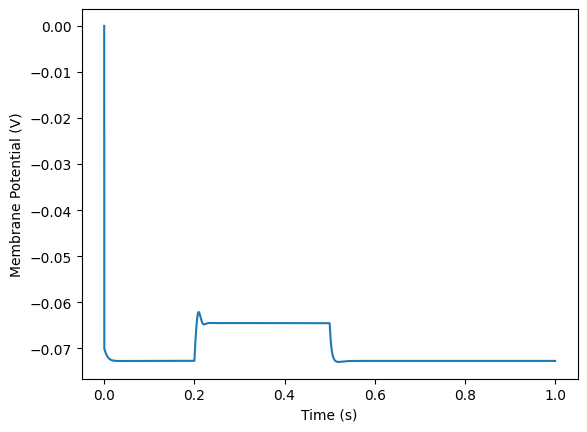

In [62]:
#Make the graph
t_vec = np.linspace(0, dt*np.size(v_out), np.size(v_out))
plt.plot(t_vec, v_out)
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential (V)')
plt.show()